This Jupyter notebook demonstrate the work done in ["Assessment of individualised dynamic environmental exposures within The World Avatar" by Chen et al., Technical Report 337, c4e-Preprint Series, Cambridge, 2025.](https://como.ceb.cam.ac.uk/preprints/337/).

The complete codes developed for this work are available under an open-source licence on GitHub in The World Avatar repository [https://github.com/cambridge-cares/TheWorldAvatar](https://github.com/cambridge-cares/TheWorldAvatar).

The notebook serves as a data exploration interface and may not generalize to any trajectory IRI provided. For general use case, please refer to the complete code in The World Avatar repository.

# Configuration

## Environment Data
Environment data from TWA knowledge graph is accessed through SPARQL endpoint. The endpoint is pre-configured at `config.env` and can be changed to other endpoints as needed.

## Trajectory Data
User is expected to provide the trajctory data in Postgres database and input the database configuration in `config.env`. 
- DB_HOST
- DB_PORT
- DB_DBNAME
- DB_USER
- DB_PASSWORD

Data is required to store in the same format as described in [here](https://github.com/TheWorldAvatar/baselib/tree/main/src/main/java/uk/ac/cam/cares/jps/base/timeseries#instantiation-in-rdb-using-timeseriesrdbclient). 

User may choose to 
- collect data with [TWA TimelineApp](https://github.com/cambridge-cares/TheWorldAvatar/tree/main/Apps/TimelineApp), which is compatible with the code in this notebook and the full version.
- instantiate data with CSV as describing in [here](https://github.com/cambridge-cares/TheWorldAvatar/tree/main/Agents/FenlandTrajectoryAgent#31-placing-the-gps-data)

## Template
SPARQL and SQL queries are provided as template files in `template/`. No additional configuration is needed.

#  Setup TWA connection

In [2]:
!pip install -q -r requirements.txt

In [3]:
from twa.kg_operations import PySparqlClient
from twa.conf import config_generic, Config

from typing import Optional, Tuple, List, Dict
import psycopg2
import pandas as pd
import os

import matplotlib.pyplot as plt
from shapely import wkb, wkt
from shapely.geometry import Point, LineString, Polygon
from pyproj import CRS, Transformer, Geod
from shapely.ops import transform
from shapely.wkb import loads as wkb_loads
from shapely.strtree import STRtree
from shapely.affinity import translate
import re
import binascii

Info: Initializing JPSGateway with resName=JpsBaseLib, jarPath=None


In [4]:
class EnvConfig(Config):
    SPARQL_QUERY_ENDPOINT: str
    TEMPLATE_DIR: str
    DB_HOST: str
    DB_PORT: str
    DB_DBNAME: str
    DB_USER: str
    DB_PASSWORD: str

In [5]:
env_confg = config_generic(EnvConfig, env_file='config.env')

sparql_client = PySparqlClient(
    query_endpoint = env_confg.SPARQL_QUERY_ENDPOINT,
    update_endpoint = ""
)

template_dir = env_confg.TEMPLATE_DIR

db_params = {
    "host": env_confg.DB_HOST,
    "port": env_confg.DB_PORT,
    "dbname": env_confg.DB_DBNAME,
    "user": env_confg.DB_USER,
    "password": env_confg.DB_PASSWORD
}

exposure_radius = 100

# Pull data from TWA

Exposure calculation util

In [6]:
def load_template(filename: str) -> str:
    filepath = os.path.join(template_dir, filename)
    with open(filepath, "r", encoding="utf-8") as f:
        content = f.read()
    return content

def execute_query(query: str, params: Optional[tuple] = None):
    with psycopg2.connect(**db_params) as conn:
        with conn.cursor() as cur:
            cur.execute(query, params)
            results = cur.fetchall()
            return results

## Fetch environment data from knowledge graph

Fetch food retails data for the year 2025 in Cambridge, UK.

In [7]:
food_hygiene_iri = "http://www.theworldavatar.com/ontology/OntoFHRS/FoodHygieneRating"
food_hygiene_rating_template = load_template('get_food_hygiene_rating.sparql')
food_hygiene_rating = pd.DataFrame(sparql_client.perform_query(food_hygiene_rating_template))
food_hygiene_rating.head()

,latitude,id,longitude
0,52.1908177,http://www.theworldavatar.com/ontology/OntoFHR...,0.1308467
1,52.1753285,http://www.theworldavatar.com/ontology/OntoFHR...,0.1330607
2,52.1745091,http://www.theworldavatar.com/ontology/OntoFHR...,0.1382032
3,52.2006931,http://www.theworldavatar.com/ontology/OntoFHR...,0.1197438
4,52.2028943,http://www.theworldavatar.com/ontology/OntoFHR...,0.1178436


Fetch greenspace data for the year 2023 in Cambridge, UK.

In [8]:

green_space_template = load_template("get_greenspace_area.sparql")
green_space = pd.DataFrame(sparql_client.perform_query(green_space_template))
green_space.head()

,feature,function,geometry
0,https://www.theworldavatar.com/kg/ontogreenspa...,Allotments Or Community Growing Spaces,0106000020346C0000010000000103000000010000000A...
1,https://www.theworldavatar.com/kg/ontogreenspa...,Allotments Or Community Growing Spaces,0106000020346C00000100000001030000000100000006...
2,https://www.theworldavatar.com/kg/ontogreenspa...,Allotments Or Community Growing Spaces,0106000020346C0000010000000103000000010000000A...
3,https://www.theworldavatar.com/kg/ontogreenspa...,Allotments Or Community Growing Spaces,0106000020346C0000010000000103000000010000000A...
4,https://www.theworldavatar.com/kg/ontogreenspa...,Allotments Or Community Growing Spaces,0106000020346C00000100000001030000000100000011...


## Fetch trajectory from database

In [9]:
def get_table_name_for_timeseries(timeseriesIRI: str) -> str:
    try:
        query_template = load_template("get_table_name_for_timeseries.sql")
        rows = execute_query(query_template, (timeseriesIRI,))
        if rows:
            return rows[0][0]
    except Exception as e:
        print(f"[Fallback] Primary get_table_name failed: {e}")

    # Try fallback
    fallback_template = load_template("get_table_name_for_timeseries_fallback.sql")
    rows = execute_query(fallback_template, (timeseriesIRI,))
    if not rows:
        raise ValueError(f"No fallback tableName found for timeseriesIRI: {timeseriesIRI}")
    return rows[0][0]

def get_timeseries_data(table_name: str, trajectory_iri: str) -> pd.DataFrame:
    """
    Retrieve raw timeseries data from database.
    Automatically detects whether 'Trip index' column exists and selects the correct SQL template.
    Returns DataFrame with appropriate columns.
    """
    try:
        check_sql = load_template("check_trip_index_column.sql")
        result = execute_query(check_sql, (table_name,))
        has_trip_index = bool(result)
    except Exception as e:
        print(f"[Trip index] Failed to check for 'Trip index' column: {e}")
        has_trip_index = False

    try:
        if has_trip_index:
            print(f"[Trip index] Detected in table: {table_name}")
            sql_template_name = "get_timeseries_data_with_trip.sql"
        else:
            print(f"[Trip index] Not found, using fallback SQL.")
            sql_template_name = "get_timeseries_data.sql"

        query_template = load_template(sql_template_name)
        query = query_template.format(table_name=table_name)
        rows = execute_query(query)

        base_cols = ["time", "column1", "column2", "column3", "column4", "column5", "column6", "column7"]
        if has_trip_index:
            base_cols.append("Trip index")

        return pd.DataFrame(rows, columns=base_cols)

    except Exception as primary_exception:
        print(f"[Fallback] Primary SQL failed for {table_name}: {primary_exception}")
        
        # Run fallback version
        try:
            fallback_template = load_template("get_timeseries_data_fallback.sql")
            query = fallback_template.format(table_name=table_name)
            rows = execute_query(query, (trajectory_iri,))

            return pd.DataFrame(rows, columns=["time", "LATITUDE", "LONGITUDE"])

        except Exception as fallback_exception:
            print(f"[Fallback] Failed for {table_name}: {fallback_exception}")
            raise fallback_exception


In [10]:
trajectory_iri = 'https://www.theworldavatar.com/kg/ontotimeseries/Timeseries_f93edf67-8144-4cea-a57d-42cd1cae7fb8'
table_name = get_table_name_for_timeseries(trajectory_iri)
trajectory_df = get_timeseries_data(table_name, trajectory_iri).sort_values(by='time', ascending=True) 

print(f'Trajectory contains {len(trajectory_df)} points')
trajectory_df.head()


[Trip index] Detected in table: bec543b5-bb83-4325-b662-df21bbd9a4cd
Trajectory contains 1020 points


,time,column1,column2,column3,column4,column5,column6,column7,Trip index
765,2025-03-08 15:50:00+00:00,0.000000,0.000000,12.126,0.0,52.213539,0.111330,0101000000E41D866D2280BC3F9B952A3C551B4A40,1
766,2025-03-08 15:50:02+00:00,4.395684,2.450594,12.126,0.0,52.213536,0.111366,01010000004762A8397882BC3FBDBEE922551B4A40,1
767,2025-03-08 15:50:04+00:00,4.763290,2.623779,12.126,0.0,52.213534,0.111404,0101000000359926B0FB84BC3F00010C11551B4A40,1
778,2025-03-08 15:50:06+00:00,6.490282,3.607515,12.126,0.0,52.213520,0.111452,0101000000A665788B1F88BC3FA774359D541B4A40,1
936,2025-03-08 15:50:08+00:00,5.604348,3.135322,12.126,0.0,52.213505,0.111491,01010000001D920A2AAE8ABC3F419ECD1F541B4A40,1


# Process trajecotry data


## Group as trips

In [11]:
# trajectory buffer
if 'Trip index' in trajectory_df.columns:
    trip_index_col = [col for col in trajectory_df.columns if col.lower().replace(" ", "_") == "trip_index"][0]
    trip_df = trajectory_df[trajectory_df[trip_index_col].fillna(0).astype(int) > 0].sort_values(by='time', ascending=True)
    grouped = trip_df.groupby(trip_index_col)

    print(f'Group of trips: {grouped.ngroups}')
else:
    trip_df = trajectory_df.copy().sort_values(by='time', ascending=True)
    trip_df["trip_index"] = 1
    grouped = trip_df.groupby("trip_index")
    print(f'Group of trips: {grouped.ngroups}')

Group of trips: 3


In [12]:
grouped.head()

,time,column1,column2,column3,column4,column5,column6,column7,Trip index
765,2025-03-08 15:50:00+00:00,0.000000,0.000000,12.126,0.0,52.213539,0.111330,0101000000E41D866D2280BC3F9B952A3C551B4A40,1
766,2025-03-08 15:50:02+00:00,4.395684,2.450594,12.126,0.0,52.213536,0.111366,01010000004762A8397882BC3FBDBEE922551B4A40,1
767,2025-03-08 15:50:04+00:00,4.763290,2.623779,12.126,0.0,52.213534,0.111404,0101000000359926B0FB84BC3F00010C11551B4A40,1
778,2025-03-08 15:50:06+00:00,6.490282,3.607515,12.126,0.0,52.213520,0.111452,0101000000A665788B1F88BC3FA774359D541B4A40,1
936,2025-03-08 15:50:08+00:00,5.604348,3.135322,12.126,0.0,52.213505,0.111491,01010000001D920A2AAE8ABC3F419ECD1F541B4A40,1
433,2025-03-08 16:51:42+00:00,0.048376,34.052049,12.126,0.0,52.205447,0.119279,010100000047E1D9B91389BE3F5BF74E154C1A4A40,2
758,2025-03-08 16:51:44+00:00,10.121046,5.490668,12.126,0.0,52.205398,0.119289,01010000007949364EBD89BE3FDA8B5C7A4A1A4A40,2
759,2025-03-08 16:51:46+00:00,6.537053,3.624433,12.126,0.0,52.205399,0.119342,0101000000E98B9C54398DBE3F3EBCB0814A1A4A40,2
760,2025-03-08 16:51:50+00:00,2.494304,2.790156,12.126,0.0,52.205386,0.119378,01010000001E25F2CA868FBE3F13C89A154A1A4A40,2
761,2025-03-08 16:51:52+00:00,4.645634,2.540904,12.126,0.0,52.205369,0.119403,0101000000D20107FF2F91BE3F1CE30089491A4A40,2


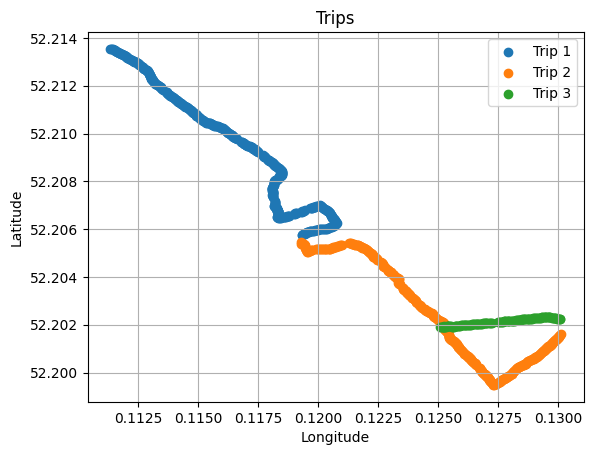

In [13]:
for name, group_df in grouped:
    coords = [
        (pt.x, pt.y)
        for pt in (wkb.loads(bytes.fromhex(hex_str)) for hex_str in list(group_df['column7']))
    ]
    x, y = zip(*coords)
    plt.scatter(x, y, label=f"Trip {name}")
    
plt.title("Trips")
plt.xlabel("Longitude")
plt.ylabel("Latitude") 
plt.grid(True)  
plt.legend()
plt.show()

## Buffer trajctory

In [14]:
group_processes = {}
coords_whole_trajectory = [
        (pt.x, pt.y)
        for pt in (wkb.loads(bytes.fromhex(hex_str)) for hex_str in list(trajectory_df['column7']))
    ]

for name, group_df in grouped:
    coords = [
        (pt.x, pt.y)
        for pt in (wkb.loads(bytes.fromhex(hex_str)) for hex_str in list(group_df['column7']))
    ]
    base_geom = LineString(coords)
    
    # centroid = base_geom.centroid
    centroid = LineString(coords_whole_trajectory).centroid
    aeqd_crs = CRS.from_proj4(f"+proj=aeqd +lat_0={centroid.y} +lon_0={centroid.x} +units=m")
    to_aeqd = Transformer.from_crs(4326, aeqd_crs, always_xy=True).transform
    to_wgs84 = Transformer.from_crs(aeqd_crs, 4326, always_xy=True).transform

    proj_base = transform(to_aeqd, base_geom)

    group_processes[name] = {
        "aeqd_crs": aeqd_crs,
        "to_aeqd": to_aeqd,
        "to_wgs84": to_wgs84,
        "buffer_proj": proj_base.buffer(exposure_radius)
        }

In [15]:
print(len(group_processes))
group_processes

3


{1: {'aeqd_crs': <Projected CRS: +proj=aeqd +lat_0=52.205364886810635 +lon_0=0.1217 ...>
  Name: unknown
  Axis Info [cartesian]:
  - E[east]: Easting (metre)
  - N[north]: Northing (metre)
  Area of Use:
  - undefined
  Coordinate Operation:
  - name: unknown
  - method: Azimuthal Equidistant
  Datum: World Geodetic System 1984
  - Ellipsoid: WGS 84
  - Prime Meridian: Greenwich,
  'to_aeqd': <bound method Transformer.transform of <Conversion Transformer: pipeline>
  Description: unknown
  Area of Use:
  - undefined>,
  'to_wgs84': <bound method Transformer.transform of <Conversion Transformer: pipeline>
  Description: Inverse of unknown
  Area of Use:
  - undefined>,
  'buffer_proj': <POLYGON ((-757.798 821.022, -762.08 823.254, -770.296 828.62, -777.947 834....>},
 2: {'aeqd_crs': <Projected CRS: +proj=aeqd +lat_0=52.205364886810635 +lon_0=0.1217 ...>
  Name: unknown
  Axis Info [cartesian]:
  - E[east]: Easting (metre)
  - N[north]: Northing (metre)
  Area of Use:
  - undefined
  C

# Exposure Calculation

## Greenspace exposure

Demonstrate area environement features exposure

### 1. Process environment data
Project area features to the same plane as the trajectory

In [16]:
def fetch_env_crs(env_data_iri: str, feature_type: str) -> str:
    """
    Returns a CRS URI for a geometry; falls back to 4326 for POINT if not found.
    """
    # Minimal change: directly load template
    template = load_template("get_crs_for_env_data.sparql")
    sparql = template.format(env_data_iri=env_data_iri)
    crs = sparql_client.perform_query(sparql)
    
    if crs:
        return crs[0]['crs']

    # If not found or error, use default value
    if feature_type.upper() == "POINT":
        return "http://www.opengis.net/def/crs/EPSG/0/4326"
    return "http://www.opengis.net/def/crs/EPSG/0/4326"

In [17]:
crs_uri = fetch_env_crs("https://www.theworldavatar.com/kg/ontogreenspace/Greenspace", "AREA")
m = re.search(r"EPSG/0/(\d+)", crs_uri)
src_epsg = int(m.group(1)) if m else 4326

for process_info in group_processes:
    to_env = Transformer.from_crs(f"EPSG:{src_epsg}", group_processes[process_info]['aeqd_crs'], always_xy=True).transform
    proj_greenspace = []
    for _, row in green_space.iterrows():
        wkb_hex = row.get("geometry", "")
        if not wkb_hex or wkb_hex == "N/A":
            continue

        try:
            poly_src = wkb_loads(binascii.unhexlify(wkb_hex), hex=True)
            proj_greenspace.append((transform(to_env, poly_src), None))
        except Exception:
            continue
    group_processes[process_info]['proj_greenspace'] = proj_greenspace

In [18]:
group_processes

{1: {'aeqd_crs': <Projected CRS: +proj=aeqd +lat_0=52.205364886810635 +lon_0=0.1217 ...>
  Name: unknown
  Axis Info [cartesian]:
  - E[east]: Easting (metre)
  - N[north]: Northing (metre)
  Area of Use:
  - undefined
  Coordinate Operation:
  - name: unknown
  - method: Azimuthal Equidistant
  Datum: World Geodetic System 1984
  - Ellipsoid: WGS 84
  - Prime Meridian: Greenwich,
  'to_aeqd': <bound method Transformer.transform of <Conversion Transformer: pipeline>
  Description: unknown
  Area of Use:
  - undefined>,
  'to_wgs84': <bound method Transformer.transform of <Conversion Transformer: pipeline>
  Description: Inverse of unknown
  Area of Use:
  - undefined>,
  'buffer_proj': <POLYGON ((-757.798 821.022, -762.08 823.254, -770.296 828.62, -777.947 834....>,
  'proj_greenspace': [(<MULTIPOLYGON (((-243830.036 -81702.26, -243825.115 -81699.602, -243822.766 ...>,
    None),
   (<MULTIPOLYGON (((-252982.53 -72885.301, -252970.215 -72996.964, -252985.652 ...>,
    None),
   (<MULTI

### 2. Trip cumulative exposure with STRtree

In [19]:
def geodesic_area(geom) -> float:
    """Calculate actual surface area in WGS84 coordinate system (unit: square meters)"""
    if geom is None or geom.is_empty:
        return 0.0
    geod = Geod(ellps='WGS84')
    if geom.geom_type == 'Polygon':
        lons, lats = zip(*list(geom.exterior.coords))
        area, _ = geod.polygon_area_perimeter(lons, lats)
        return abs(area)
    elif geom.geom_type == 'MultiPolygon':
        return sum(geodesic_area(poly) for poly in geom.geoms)
    else:
        return 0.0

In [20]:
tree = STRtree([g for g, _ in proj_greenspace])
results = []
for trip in group_processes:
    buf_proj = group_processes[trip]['buffer_proj']
    to_wgs84 = group_processes[trip]['to_wgs84']

    spatial_ix = tree.query(buf_proj)

    area_count = 0
    total_area = 0.0

    for i in spatial_ix:
        poly_proj, _ = proj_greenspace[i]
        inter_proj = poly_proj.intersection(buf_proj)
        if inter_proj.is_empty:
            continue
        inter_ll = transform(to_wgs84, inter_proj)
        total_area += geodesic_area(inter_ll)
        area_count += 1
    results.append({'tirp': trip, 'area_count': area_count, 'total_area': total_area})

results

[{'tirp': 1, 'area_count': 6, 'total_area': 7259.950416997119},
 {'tirp': 2, 'area_count': 8, 'total_area': 64692.075987392614},
 {'tirp': 3, 'area_count': 4, 'total_area': 69885.39407514577}]

In [21]:
sum(item['area_count'] for item in results)

18

In [22]:
sum(item['total_area'] for item in results)

141837.4204795355

### 3. Trajectory pointwise exposure

In [23]:
proj_env = proj_greenspace
tree = STRtree([g for g, _ in proj_greenspace])
def pointwise_area_exposure(row):
    to_aeqd = group_processes[row['Trip index']]['to_aeqd']
    to_wgs84 = group_processes[row['Trip index']]['to_wgs84']
    geom = row['column7']
    
    lon, lat = wkb.loads(bytes.fromhex(geom)).x, wkb.loads(bytes.fromhex(geom)).y
    pt_proj = Point(to_aeqd(lon, lat))
    buf_template = Point(0, 0).buffer(exposure_radius)
    circ_proj = translate(buf_template, pt_proj.x, pt_proj.y)
    idxs_pt = tree.query(circ_proj)
    area_m2 = 0.0
    for i in idxs_pt:
        poly_proj, _ = proj_env[i]
        inter_proj = poly_proj.intersection(circ_proj)
        if inter_proj.is_empty:
            continue
        inter_ll = transform(to_wgs84, inter_proj)
        area_m2 += geodesic_area(inter_ll)
    return area_m2

In [24]:
pointwise_cal_df = trip_df.copy()
pointwise_cal_df['gs_area'] = pointwise_cal_df.apply(pointwise_area_exposure, axis=1)

In [25]:
pointwise_cal_df.head()

,time,column1,column2,column3,column4,column5,column6,column7,Trip index,gs_area
765,2025-03-08 15:50:00+00:00,0.000000,0.000000,12.126,0.0,52.213539,0.111330,0101000000E41D866D2280BC3F9B952A3C551B4A40,1,1.173699
766,2025-03-08 15:50:02+00:00,4.395684,2.450594,12.126,0.0,52.213536,0.111366,01010000004762A8397882BC3FBDBEE922551B4A40,1,0.191401
767,2025-03-08 15:50:04+00:00,4.763290,2.623779,12.126,0.0,52.213534,0.111404,0101000000359926B0FB84BC3F00010C11551B4A40,1,1.339990
778,2025-03-08 15:50:06+00:00,6.490282,3.607515,12.126,0.0,52.213520,0.111452,0101000000A665788B1F88BC3FA774359D541B4A40,1,10.537033
936,2025-03-08 15:50:08+00:00,5.604348,3.135322,12.126,0.0,52.213505,0.111491,01010000001D920A2AAE8ABC3F419ECD1F541B4A40,1,26.700163


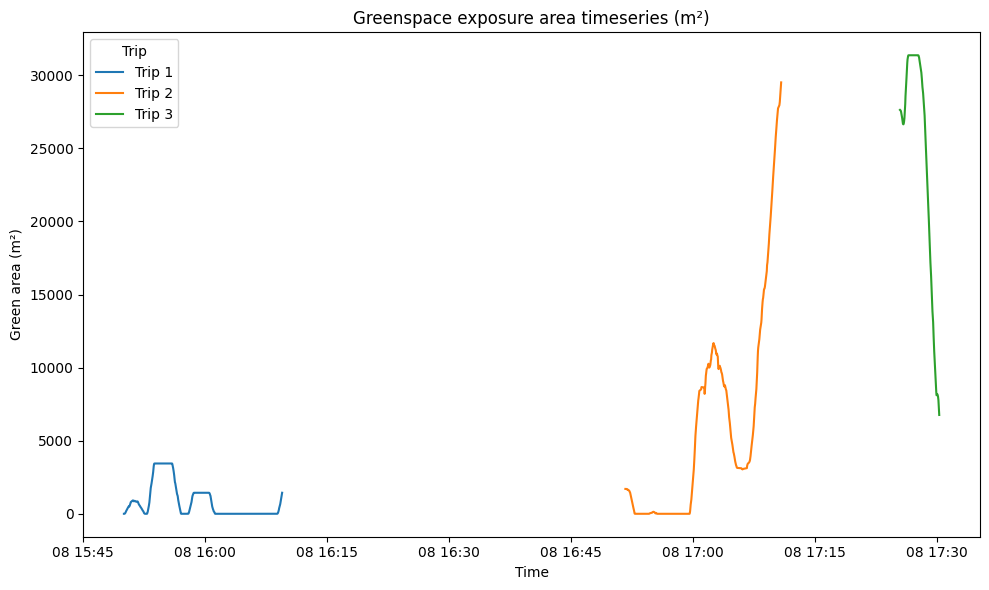

In [26]:
grouped_result = pointwise_cal_df.groupby(trip_index_col)
fig, ax = plt.subplots(figsize=(10, 6))

for group_name, df in grouped_result:
    ax.plot(df['time'], df['gs_area'], label=f'Trip {group_name}')

ax.set_title("Greenspace exposure area timeseries (m²)")
ax.set_xlabel("Time")
ax.set_ylabel("Green area (m²)")
ax.legend(title="Trip")

plt.tight_layout()
plt.show()

## Food retails exposure

### 1. Process environment features
Project point features to the same plane as the trajectory

In [27]:
food_hygiene_rating.head()

,latitude,id,longitude
0,52.1908177,http://www.theworldavatar.com/ontology/OntoFHR...,0.1308467
1,52.1753285,http://www.theworldavatar.com/ontology/OntoFHR...,0.1330607
2,52.1745091,http://www.theworldavatar.com/ontology/OntoFHR...,0.1382032
3,52.2006931,http://www.theworldavatar.com/ontology/OntoFHR...,0.1197438
4,52.2028943,http://www.theworldavatar.com/ontology/OntoFHR...,0.1178436


In [28]:
for trip in group_processes:
    to_aeqd = group_processes[trip]['to_aeqd']
    proj_food = []
    for _, row in food_hygiene_rating.iterrows():
        try:
            lon, lat = float(row["longitude"]), float(row["latitude"])
            proj_food.append((Point(to_aeqd(lon, lat)), row.get("id", f"{lon},{lat}")))
        except Exception:
            continue
    group_processes[trip]['proj_food'] = proj_food

### 2. STRtree + cumulative exposure
Calculate food retails exposure of the trajectory

In [29]:
results = []
tree = STRtree([g for g, _ in proj_food])

for trip in group_processes:
    buf_proj = group_processes[trip]['buffer_proj']
    spatial_ix = tree.query(buf_proj)

    point_count = 0

    visited = set()
    for i in spatial_ix:
        pt_proj, uid = proj_food[i]
        if buf_proj.intersects(pt_proj):
            visited.add(uid)
    results.append({'tirp': trip, 'point_count': len(visited)})

In [30]:
print(f'Food retails exposure count {results}')

Food retails exposure count [{'tirp': 1, 'point_count': 129}, {'tirp': 2, 'point_count': 152}, {'tirp': 3, 'point_count': 14}]


### 3. Trajectory pointwise exposure 
Calculate food retails exposure at individual trajectory points

In [31]:
proj_env = proj_food
tree = STRtree([g for g, _ in proj_food])
def pointwise_point_exposure(row):
    geom = row['column7']
    to_aeqd = group_processes[row['Trip index']]['to_aeqd']
    
    lon, lat = wkb.loads(bytes.fromhex(geom)).x, wkb.loads(bytes.fromhex(geom)).y
    pt_proj = Point(to_aeqd(lon, lat))
    idxs_pt = tree.query(pt_proj.buffer(exposure_radius))
    cnt = sum(
        1 for i in idxs_pt
        if pt_proj.distance(proj_env[i][0]) <= exposure_radius
    )
    return cnt

In [32]:
pointwise_cal_df = trip_df.copy().sort_values(by='time', ascending=True)
pointwise_cal_df['food_count'] = pointwise_cal_df.apply(pointwise_point_exposure, axis=1)

pointwise_cal_df.head()

,time,column1,column2,column3,column4,column5,column6,column7,Trip index,food_count
765,2025-03-08 15:50:00+00:00,0.000000,0.000000,12.126,0.0,52.213539,0.111330,0101000000E41D866D2280BC3F9B952A3C551B4A40,1,2
766,2025-03-08 15:50:02+00:00,4.395684,2.450594,12.126,0.0,52.213536,0.111366,01010000004762A8397882BC3FBDBEE922551B4A40,1,2
767,2025-03-08 15:50:04+00:00,4.763290,2.623779,12.126,0.0,52.213534,0.111404,0101000000359926B0FB84BC3F00010C11551B4A40,1,2
778,2025-03-08 15:50:06+00:00,6.490282,3.607515,12.126,0.0,52.213520,0.111452,0101000000A665788B1F88BC3FA774359D541B4A40,1,2
936,2025-03-08 15:50:08+00:00,5.604348,3.135322,12.126,0.0,52.213505,0.111491,01010000001D920A2AAE8ABC3F419ECD1F541B4A40,1,2


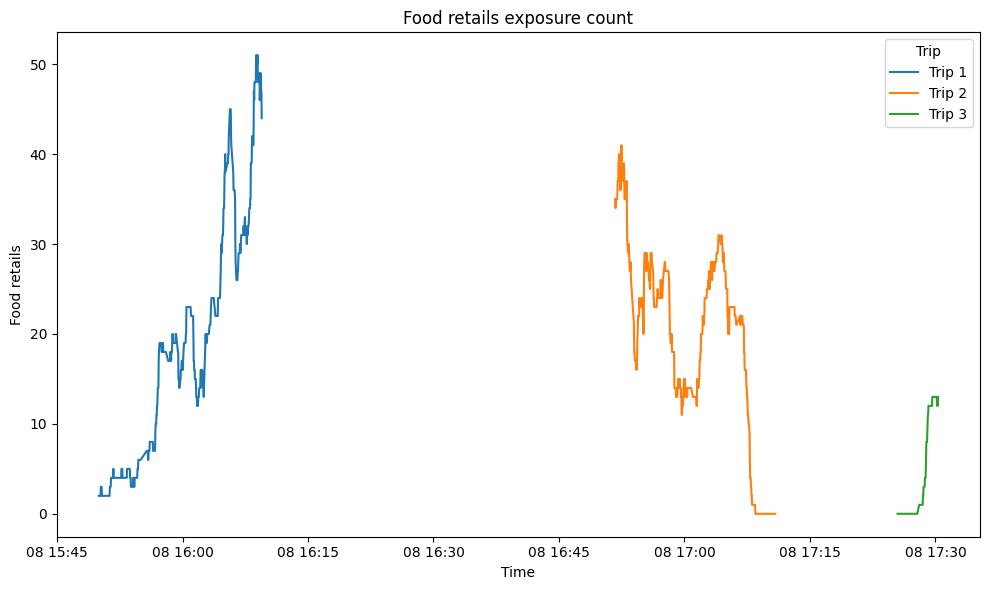

In [33]:
grouped_result = pointwise_cal_df.groupby(trip_index_col)
fig, ax = plt.subplots(figsize=(10, 6))  # Single shared plot

for group_name, df in grouped_result:
    ax.plot(df['time'], df['food_count'], label=f'Trip {group_name}')

ax.set_title("Food retails exposure count")
ax.set_xlabel("Time")
ax.set_ylabel("Food retails")
ax.legend(title="Trip")

plt.tight_layout()
plt.show()